In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,1617
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,1617
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,1617
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,1617
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,1617
5,Abel_Hernández,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,5,1617
6,Adama_Diomande,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,8,1617
7,Adam_Clayton,1,3,90,Middlesbrough,Stoke City,0.452793,0.718705,True,2,1617
8,Adam_Federici,1,1,0,Bournemouth,Manchester United,0.384921,1.983179,True,0,1617
9,Adam_Forshaw,1,3,69,Middlesbrough,Stoke City,0.452793,0.718705,True,1,1617


In [5]:
train_df.shape

(67936, 11)

In [6]:
# find validation cut point - index for 18-19 season second half (gw 19)
valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
#valid_start = train_df[(train_df['season'] == '1819')].index.min()
valid_end = train_df.index.max()

In [7]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
season                                  object
dtype: object

In [8]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [9]:
# set dependent variable
dep_var = 'total_points'

In [10]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [11]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [12]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [13]:
# set range of predictions - 0 to current 1.1 times current max
max_y = np.max(train_df['total_points'])*1.1
y_range = torch.tensor([0, max_y], device=defaults.device)

In [14]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [15]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1055, 79)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(27, 10)
    (4): Embedding(27, 10)
    (5): Embedding(3, 3)
    (6): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=124, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


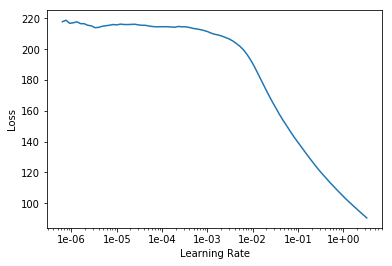

In [17]:
learn.recorder.plot()

In [122]:
# no market value, latest half season validation
learn.fit_one_cycle(7, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,4.671103,4.058165,1.975258,00:05
1,4.023581,4.245531,1.991781,00:05
2,4.069503,4.208030,1.985547,00:05
3,3.735965,4.595274,2.119409,00:05
4,3.585393,3.877654,1.932921,00:05
5,3.206583,3.711629,1.876884,00:06
6,3.050195,3.812535,1.910187,00:05


In [18]:
# market value, latest half season validation
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.719547,3.793970,1.889232,00:06
1,3.646537,3.850209,1.922720,00:06
2,3.635169,3.570860,1.846240,00:06
3,3.082052,3.468595,1.812481,00:06


In [97]:
# no market value, new season validation
learn.fit_one_cycle(7, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,4.190550,6.135087,2.440161,00:05
1,3.857543,3.978027,1.933421,00:05
2,3.710502,3.876259,1.927505,00:05
3,3.443164,3.826964,1.915945,00:05
4,3.446122,3.713155,1.877538,00:05
5,3.098882,3.761742,1.897482,00:05
6,2.939469,3.802439,1.905856,00:05


In [105]:
# market value, new season validation
learn.fit_one_cycle(7, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.974407,3.883185,1.914001,00:05
1,3.753403,4.662024,2.126512,00:05
2,3.625479,3.772259,1.889259,00:05
3,3.840882,3.775510,1.897972,00:05
4,3.616885,3.812484,1.901750,00:05
5,3.309392,3.734806,1.886369,00:05
6,2.903124,3.771559,1.897273,00:05


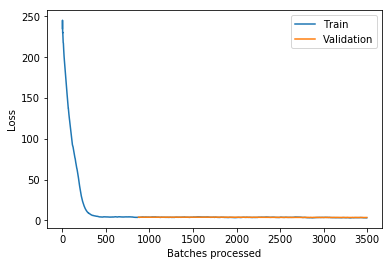

In [19]:
learn.recorder.plot_losses()

In [20]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [21]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,predicted_points
63316,Alex_Smithies,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.085906
63354,Anthony_Pilkington,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.144437
63363,Aron_Gunnarsson,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,2.743201
63367,Ashley Darel Jazz_Richards,32,2,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.200424
63408,Bobby_Reid,32,4,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.162794
63414,Brian_Murphy,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.125014
63418,Bruno_Ecuele Manga,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,1.635465
63425,Callum_Paterson,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.181799
63493,Danny_Ward_2,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,0.152155
63503,David Junior_Hoilett,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,2,1819,3.147479


In [22]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,predicted_points
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,1819,8.885129
63182,Mohamed_Salah,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,2,1819,8.846229
61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,1819,8.401267
60486,Mohamed_Salah,26,3,90,Liverpool,Bournemouth,2.177887,0.418108,True,8,1819,8.285473
59235,Mohamed_Salah,24,3,90,Liverpool,Leicester City,2.177887,0.796050,True,2,1819,8.054166
58652,Mohamed_Salah,23,3,90,Liverpool,Crystal Palace,2.177887,0.634856,True,15,1819,8.027211
56366,Mohamed_Salah,19,3,90,Liverpool,Newcastle United,2.177887,0.483921,True,12,1819,7.976093
65818,Mohamed_Salah,35,3,90,Liverpool,Cardiff City,2.177887,0.183890,False,6,1819,7.955802
58075,Mohamed_Salah,22,3,90,Liverpool,Brighton and Hove Albion,2.177887,0.417745,False,11,1819,7.822972
62786,Mohamed_Salah,30,3,90,Liverpool,Burnley,2.177887,0.449442,True,5,1819,7.793598


In [25]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.08116340637207

In [26]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])

4.986

In [27]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [28]:
remaining_season_df.head(10)

,gw,team,opponent_team,player,position,price,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,1,Liverpool,Norwich,Alex_Oxlade-Chamberlain,3,6.5,True,2.40329,0.190038,1920,90
1,1,Liverpool,Norwich,Andrew_Robertson,2,7.0,True,2.40329,0.190038,1920,90
2,1,Liverpool,Norwich,Simon_Mignolet,1,4.5,True,2.40329,0.190038,1920,90
3,1,Liverpool,Norwich,Dejan_Lovren,2,5.5,True,2.40329,0.190038,1920,90
4,1,Liverpool,Norwich,Joseph_Gomez,2,5.5,True,2.40329,0.190038,1920,90
5,1,Liverpool,Norwich,Joel_Matip,2,5.5,True,2.40329,0.190038,1920,90
6,1,Liverpool,Norwich,Jordan_Henderson,3,5.5,True,2.40329,0.190038,1920,90
7,1,Liverpool,Norwich,Adam_Lallana,3,6.0,True,2.40329,0.190038,1920,90
8,1,Liverpool,Norwich,James_Milner,3,5.5,True,2.40329,0.190038,1920,90
9,1,Liverpool,Norwich,Roberto_Firmino,4,9.5,True,2.40329,0.190038,1920,90


In [43]:
# create new databunch, including remaining season as test set
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [44]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [45]:
# train as before
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,4.129379,4.133836,1.967832,00:06
1,3.327464,3.715800,1.878311,00:06
2,3.510802,3.564620,1.834917,00:06
3,3.290228,3.495810,1.816640,00:06


In [46]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [47]:
remaining_season_df.shape

(16074, 12)

In [48]:
# quick look
remaining_season_df.head(20)
#.sort_values(by='predicted_points', ascending=False)

,gw,team,opponent_team,player,position,price,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
0,1,Liverpool,Norwich,Alex_Oxlade-Chamberlain,3,6.5,True,2.430207,0.190403,1920,90,4.572116
1,1,Liverpool,Norwich,Andrew_Robertson,2,7.0,True,2.430207,0.190403,1920,90,6.481074
2,1,Liverpool,Norwich,Simon_Mignolet,1,4.5,True,2.430207,0.190403,1920,90,4.449578
3,1,Liverpool,Norwich,Dejan_Lovren,2,5.5,True,2.430207,0.190403,1920,90,5.288513
4,1,Liverpool,Norwich,Joseph_Gomez,2,5.5,True,2.430207,0.190403,1920,90,5.319177
5,1,Liverpool,Norwich,Joel_Matip,2,5.5,True,2.430207,0.190403,1920,90,4.661710
6,1,Liverpool,Norwich,Jordan_Henderson,3,5.5,True,2.430207,0.190403,1920,90,2.981629
7,1,Liverpool,Norwich,Adam_Lallana,3,6.0,True,2.430207,0.190403,1920,90,5.033906
8,1,Liverpool,Norwich,James_Milner,3,5.5,True,2.430207,0.190403,1920,90,4.684102
9,1,Liverpool,Norwich,Roberto_Firmino,4,9.5,True,2.430207,0.190403,1920,90,5.963749


In [49]:
# write to predictions.csv
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'predicted_points']]
predictions.to_csv('predictions.csv')